# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

from quantum_electron.electron_counter import FullModel
from quantum_electron.schrodinger_solver import find_minimum_location, make_potential
from quantum_electron.utils import r2xy, xy2r
from zeroheliumkit.fem import FieldAnalyzer
from zeroheliumkit import Structure, Rectangle,GeomCollection
from zeroheliumkit.src.importing import Reader_GDS
from zeroheliumkit.src.plotting import default_ax
from zeroheliumkit.src.settings import *
from zeroheliumkit.helpers.constants import *

# Device and FEM Results

TransferDevice.gds // Layers in cell 'TOP': {1, 2, 3}


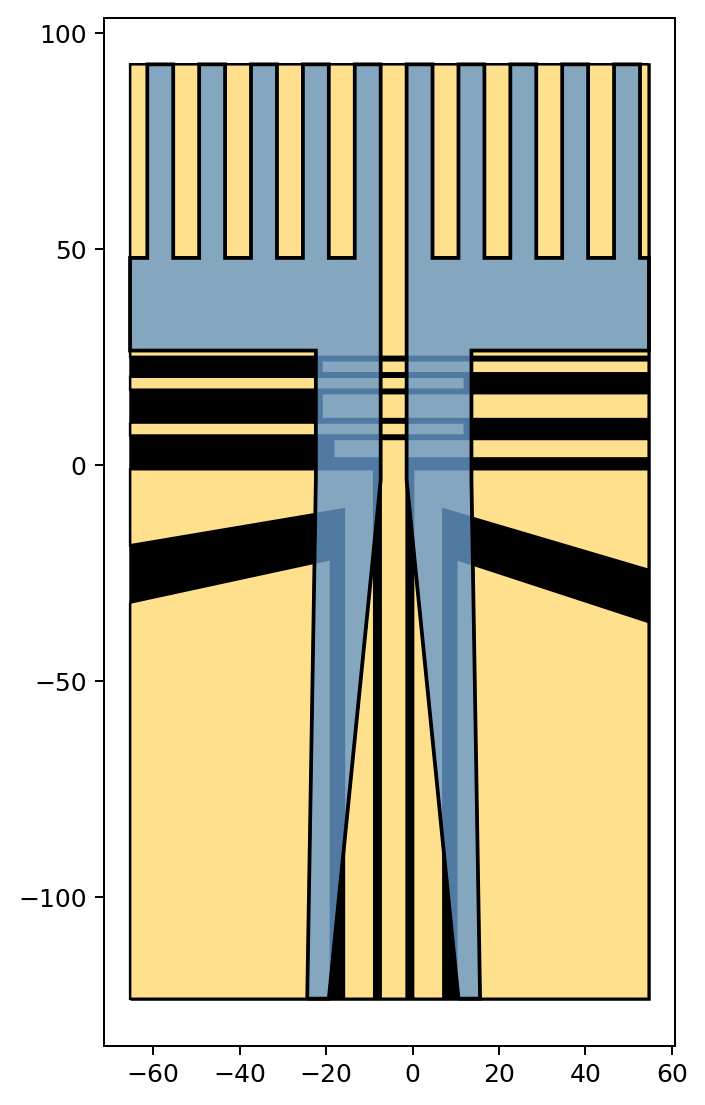

In [3]:
plot_config = {'wafer':BLACK,'bottom':YELLOW2,'top':(BLUE,0.8)}
# Read File
file = Reader_GDS('TransferDevice.gds')
file.import2zhk("TOP")
device = GeomCollection(file.geometries)
# Rename Layers
device.rename_layer('L1','bottom')
device.rename_layer('L2','top')
device.rename_layer('L3','wafer')
device.layers
#Show Device
device.quickplot(plot_config)

ph = FieldAnalyzer(("TransferDevice_phi_xy.txt", 'phi', '2Dmap'))
p = ph.phi

# Definitions 

In [4]:
hbar = 1.05457182e-34       # [J*s]             plank's constant          
epsilon_0 = 8.854e-12       # [F/m]             vacuum permittivity
mu_0 = 1.25663706e-6        # [N/A^2]   vacuum permeability
epsilon_He = 1.057          # [1]               dielectric constant of helium
qe = 1.602e-19              # [Coulombs]        electron charge
me = 9.1093837e-31          # [kg]              electron mass
g = 9.81                    # [m/s^2]           gravity constant
alpha = 3.58e-4             # [N/p]             surface tension
rho = 146                   # [kg/m^3]          helium density
kb = 1.3806e-23             # [J/K]             boltzman constant
speedoflight = 299792458.0  # [m/s]             speed of light

GHz = 1e9
MHz = 1e6
kHz = 1e3

cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

options = {"include_screening" : False, # Include screening of electron-electron interactions due to thin film.
           "screening_length" : 0.6e-6, # Typically helium thickness.
           "potential_smoothing" : 1e-1, # Numerical smoothing of the splines (gets rid of some noise, can introduce artifacts)
           "remove_unbound_electrons" : True, # Removes electrons if they shot outside the solution box.
           "remove_bounds" : (-1.0e-6, 1.0e-6), # Sets which electrons should be removed if above is True.
           "trap_annealing_steps" : [0.5] * 0, # List of annealing temperatures, length determines the number of steps
           "max_x_displacement" : 0.1e-6, # Maximum x-displacement of solved electron positions during annealing.
           "max_y_displacement" : 0.1e-6} # Maximum y-displacement of solved electron positions during annealing.

# Coupling Constants

In [5]:
ph.phi.keys()

dict_keys(['Barrier', 'Door1', 'Door2', 'Reservoir', 'Sense', 'ThinFilm', 'Top', 'Twiddle', 'xlist', 'ylist'])

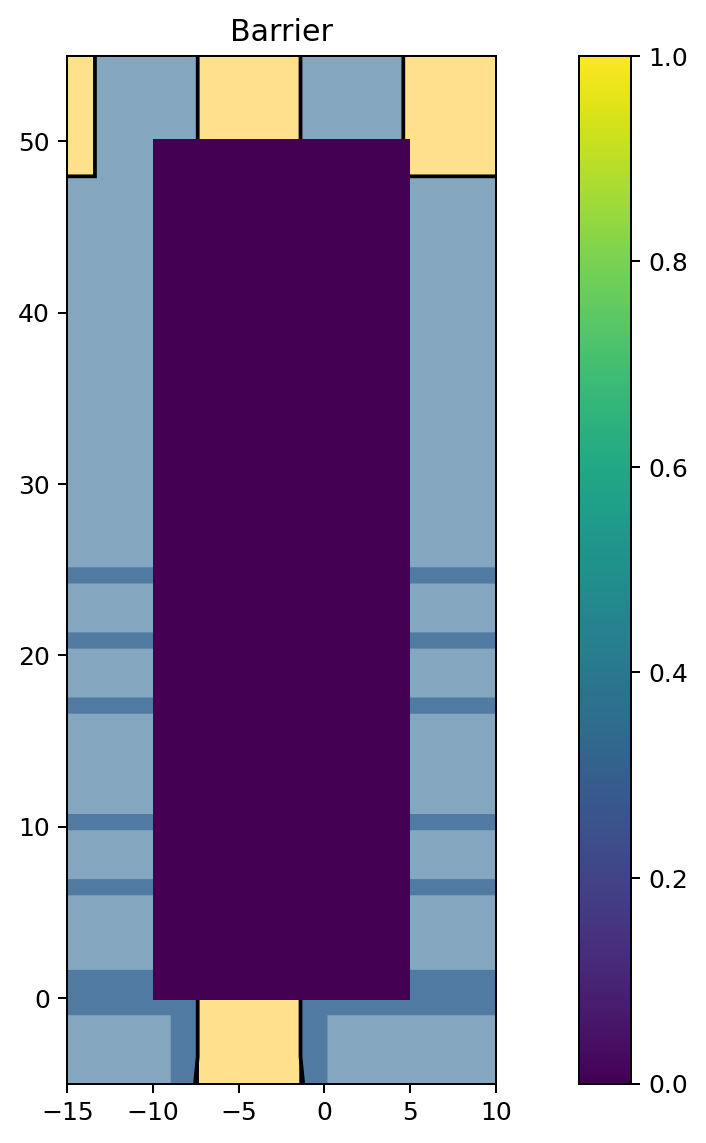

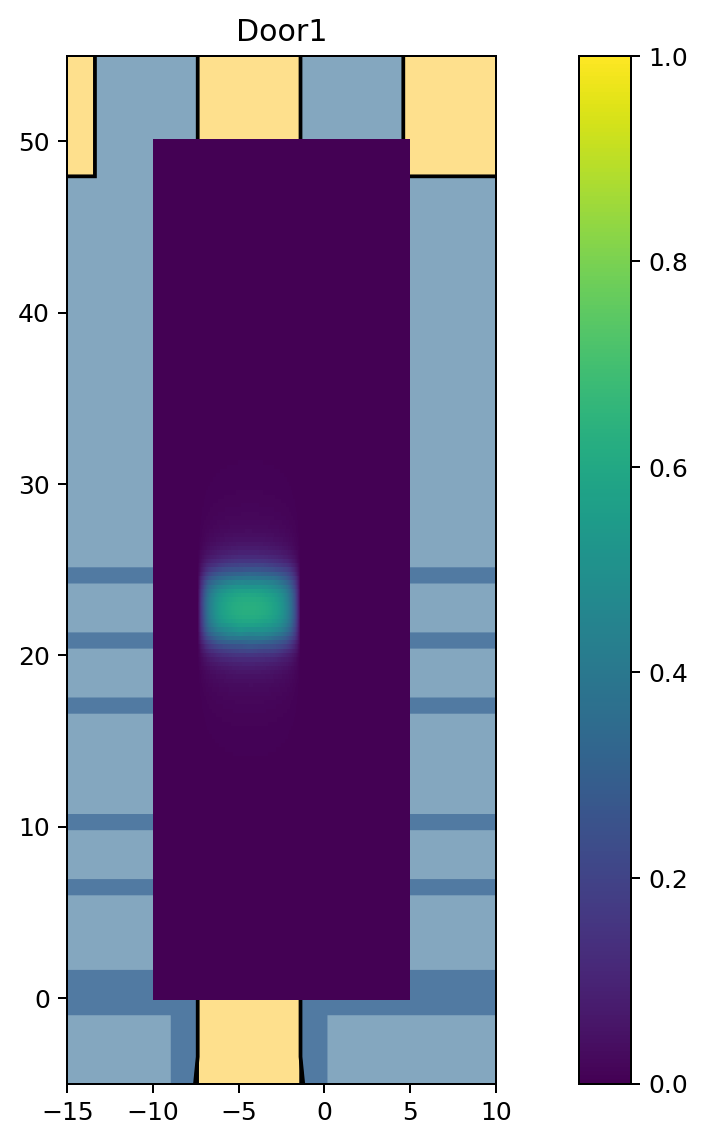

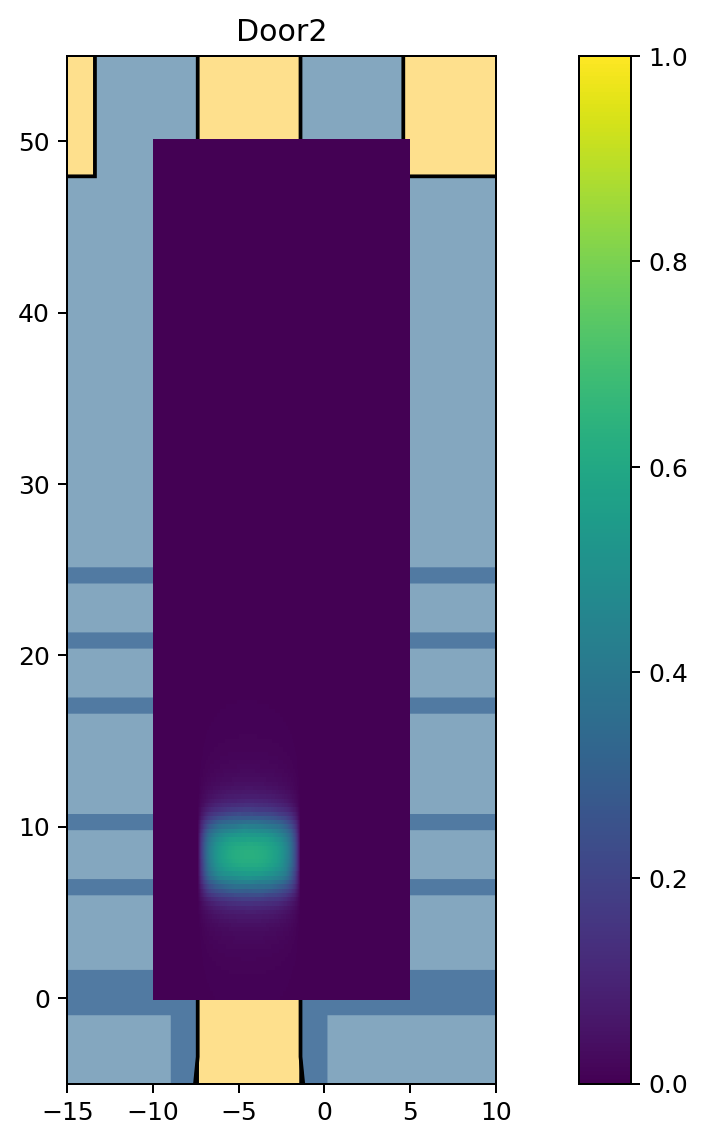

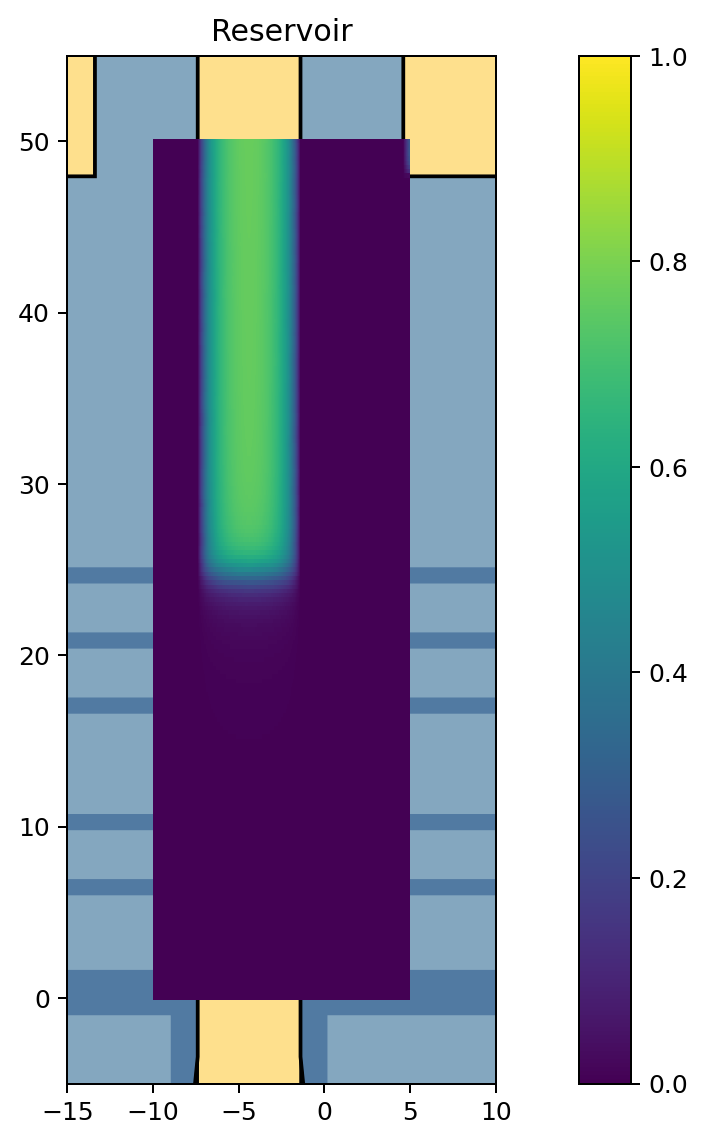

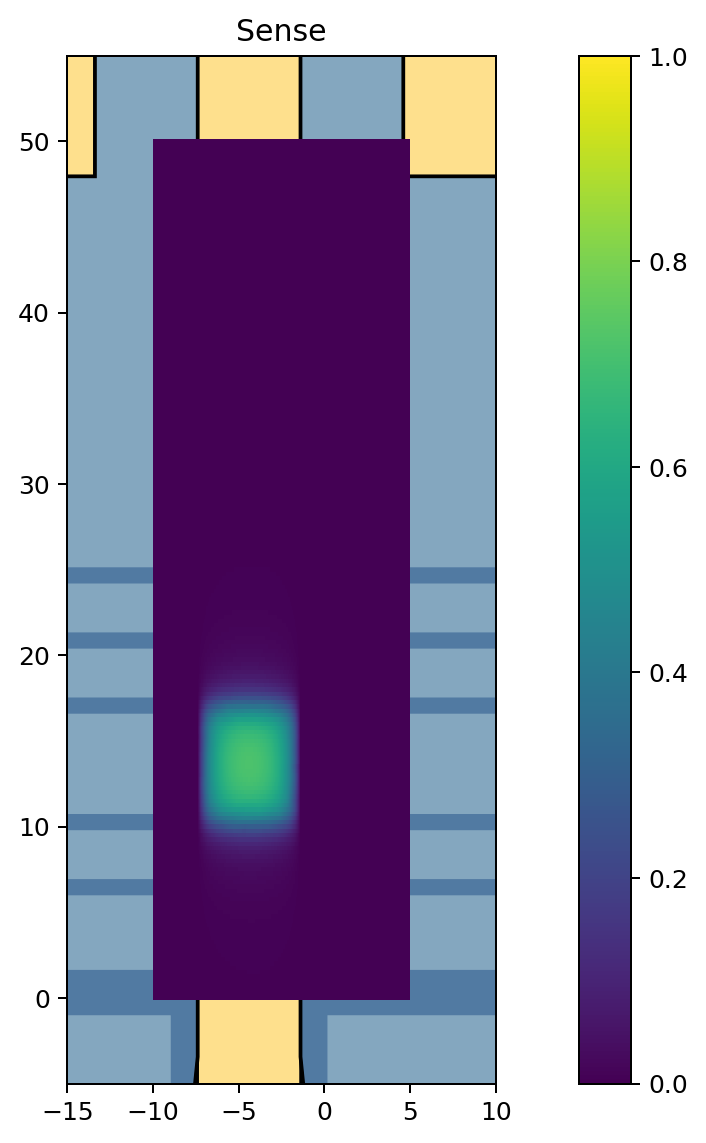

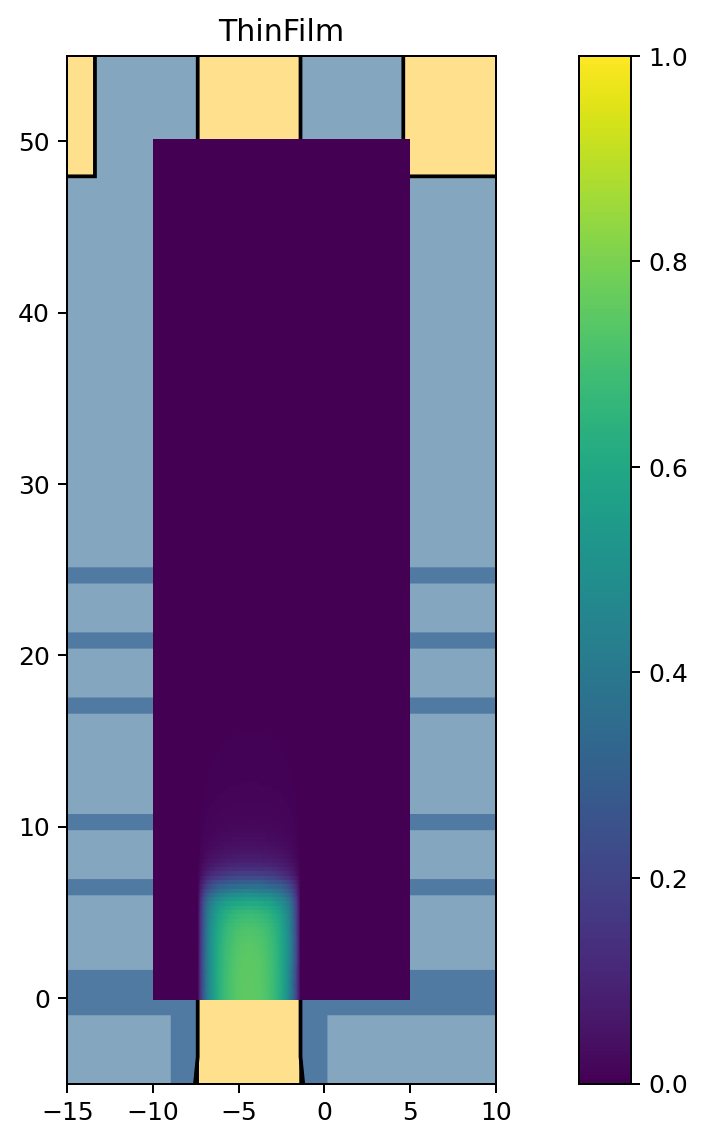

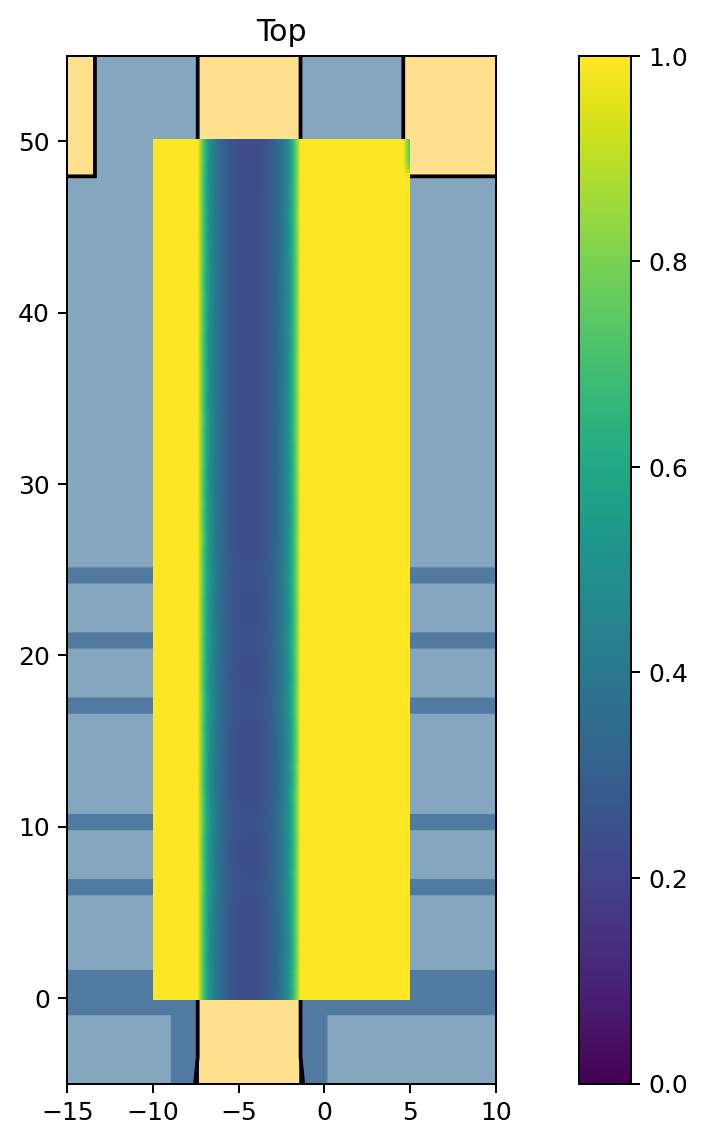

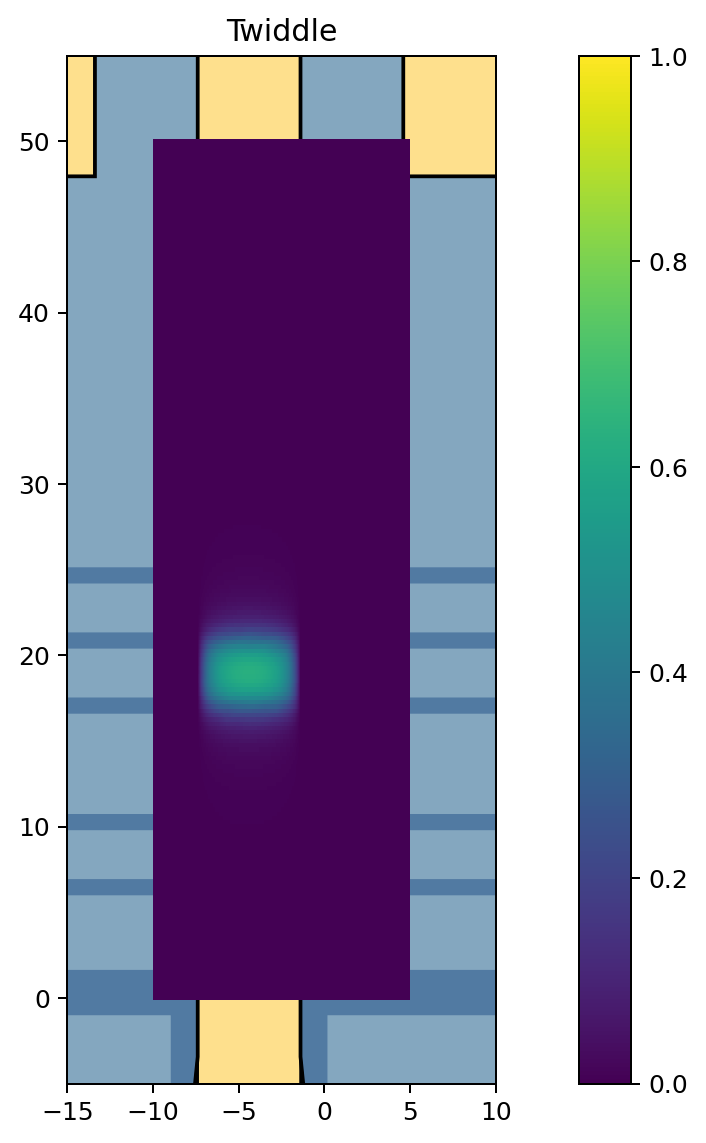

In [6]:
# By setting the voltage of each gate to 1, we can plot the coupling constants
voltages = {
    'Barrier':0,
    'Door1':0,
    'Door2':0,
    'Reservoir':0,
    'Sense':0,
    'ThinFilm':0,
    'Top':0,
    'Twiddle':0,
}
for k,v in voltages.items():
    voltages[k] = 1
    x,y,z = ph.potential(ph.phi,voltages)

    x,y,z = ph.potential(ph.phi,voltages)
    device.quickplot(plot_config)
    plt.pcolormesh(x,y,z.T,alpha = 1)
    plt.clim(0,1)
    plt.colorbar()
    plt.xlim(-15,10)
    plt.ylim(-5,55)
    plt.title(k)
    plt.show()

    voltages[k] = 0

# DC Voltage Config

### Look at a random voltage config

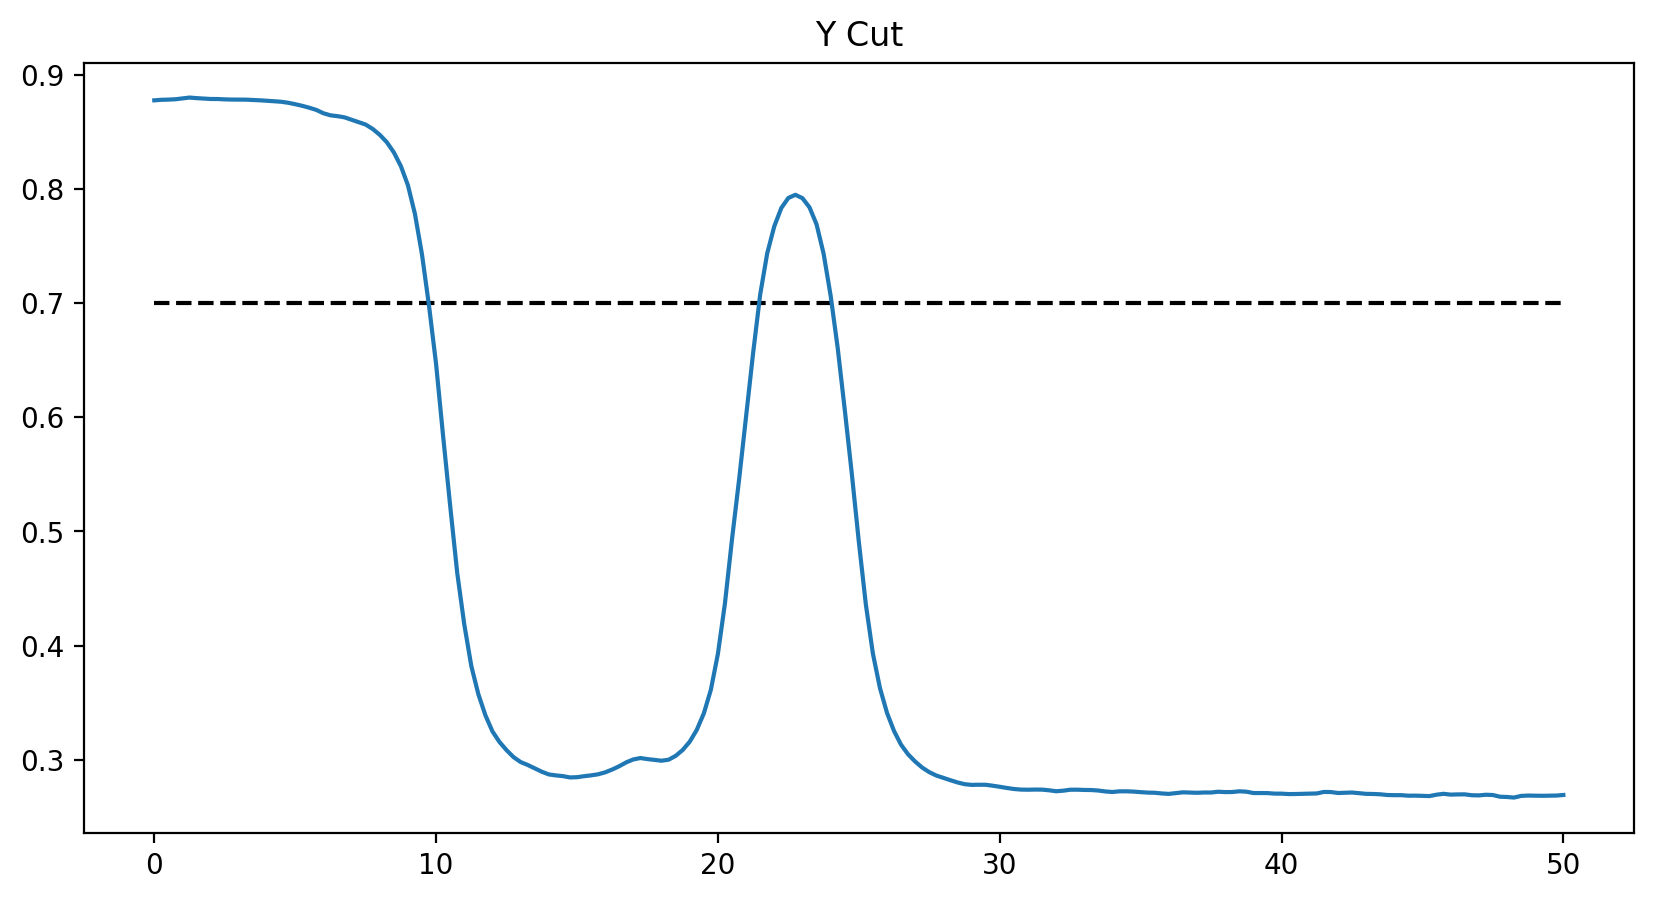

In [7]:
voltages = {
    'Barrier':-1,
    'Door1':-1,
    'Door2':-1,
    'Reservoir':0,
    'Sense':0,
    'ThinFilm':-1,
    'Top':-0.7,
    'Twiddle':0,
}


x,y,z = ph.potential(p,voltages)

# Take a line cut along the middle and add a dashed line at the top ground plane potential
xC = int(len(x)/2)
plt.figure(figsize=(10,5))
plt.title('Y Cut')
plt.hlines(-voltages['Top'],y.min(),y.max(),'k','--')
plt.plot(y,-z[xC,:])



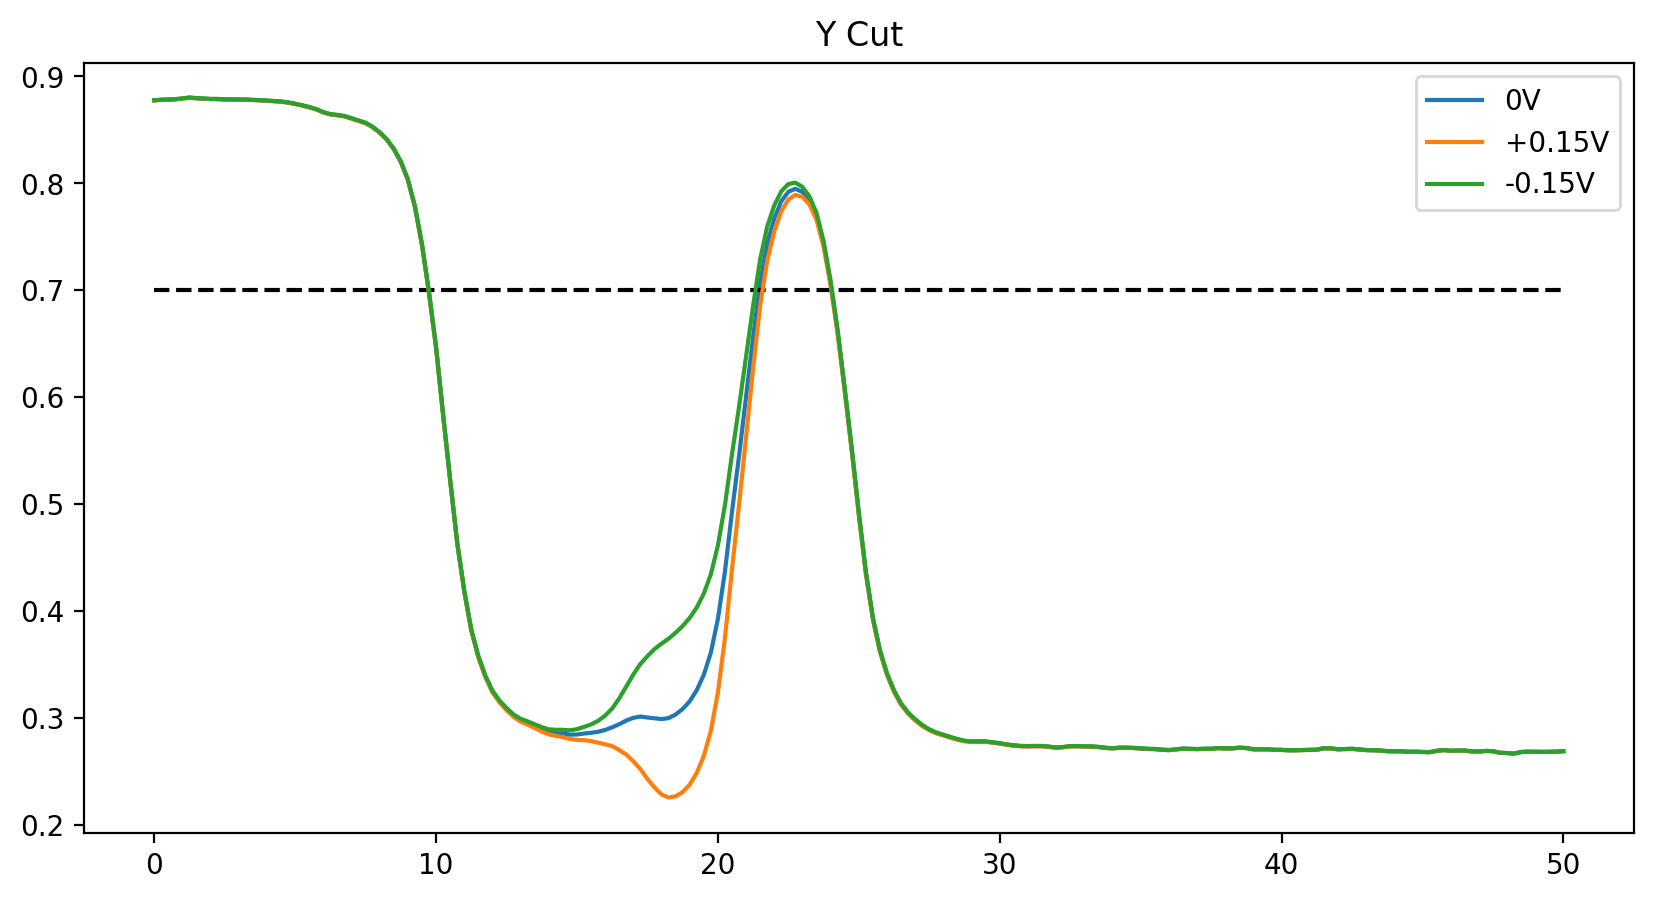

In [8]:
voltages = {
    'Barrier':-1,
    'Door1':-1,
    'Door2':-1,
    'Reservoir':0,
    'Sense':0,
    'ThinFilm':-1,
    'Top':-0.7,
    'Twiddle':0,
}
x,y,z = ph.potential(p,voltages)
xC = int(len(x)/2)

# Plot some line cuts along the center 
plt.figure(figsize=(10,5))
plt.title('Y Cut')
plt.plot(y,-z[xC,:],label='0V')
plt.hlines(-voltages['Top'],y.min(),y.max(),'k','--')

# Add a line, but with the twiddle at +0.15
voltages['Twiddle'] = .15
x,y,z = ph.potential(p,voltages)
plt.plot(y,-z[xC,:],label='+0.15V')

# Add a line, but with the twiddle at -0.15
voltages['Twiddle'] = -.15
x,y,z = ph.potential(p,voltages)
plt.plot(y,-z[xC,:],label='-0.15V')

plt.legend()
plt.show()


# Electron Counting

## Functions

In [9]:
import numpy as np

def generate_coords_deterministic(N, x0,y0,min_spacing=0):
    coords = []
    if min_spacing == 0:
        a = 0.1
    else:
        a = min_spacing
    r_max = a

    count = 0
    while count < N:
        coords.clear()
        r_max += a * 0.5  
        n_rings = int(r_max / a) + 1
        for i in range(-n_rings, n_rings + 1):
            for j in range(-n_rings, n_rings + 1):
                x = a * (i + 0.5 * j)
                y = a * (np.sqrt(3)/2) * j
                r = np.sqrt(x**2 + y**2)
                if r <= r_max:
                    coords.append((x0 + x, y0 + y))
                    if len(coords) >= N:
                        break
            if len(coords) >= N:
                break
        count = len(coords)

    return np.array(coords[:N])

def get_min_energy_forcemethod(fm,n_electrons: int=10,n_timesteps = 20_000,dt = 1e-13,gamma = -.01,init_coords=None,returnAll = False):
    gamma = gamma * me / dt # This is the damping parameter. 
    if init_coords is None:
        initial_condition = generate_coords_deterministic(int(N),0,0,0.15).flatten()*1e-6
    else:
        initial_condition = init_coords
    r = np.zeros((2 * n_electrons, n_timesteps+2))

    r[:, 0] = initial_condition
    r[:, 1] = initial_condition

    for k in range(2, n_timesteps+2):
        prefactor = 1 / (me / dt ** 2 - gamma / dt)
        F = - qe * fm.grad_total(r[:, k-1])
        r[:, k] = prefactor * (F - r[:, k-1] * (-2 * me / dt ** 2 + gamma / dt) - r[:, k-2] * me / dt ** 2)
    if returnAll:
        electron_positions = r
    else:
        electron_positions = r[:, -1]
    return electron_positions

## Solve Postions

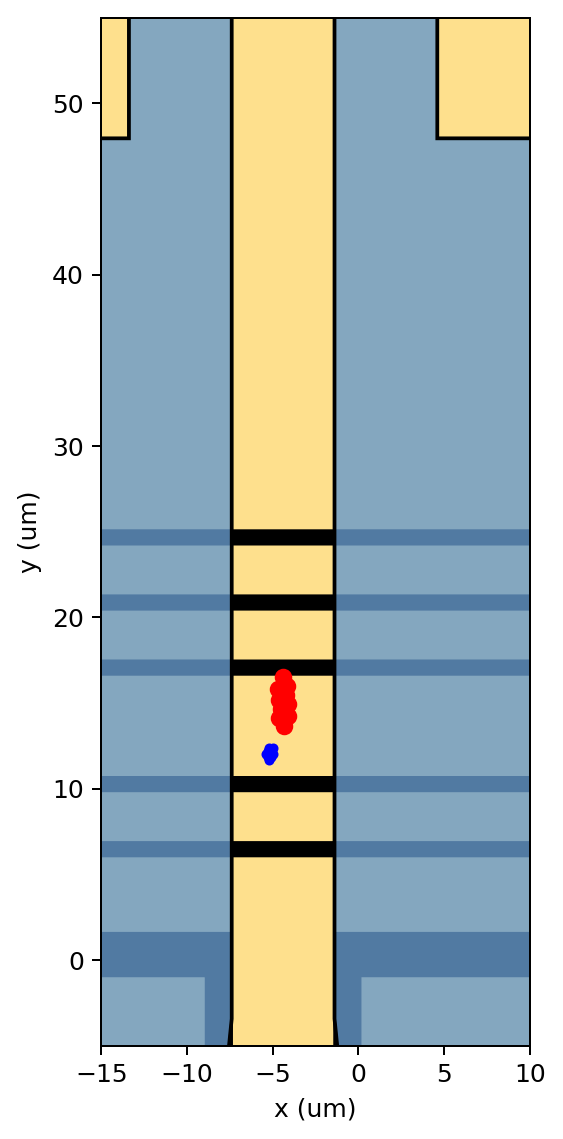

In [15]:
voltages = {
    'Barrier':-1,
    'Door1':-1,
    'Door2':-1,
    'Reservoir':0,
    'Sense':0,
    'ThinFilm':-1,
    'Top':-0.7,
    'Twiddle':0,
}

N = 10
min_spacing = 0.2
x0,y0 = -5,12     # where the electrons will be placed initially

x,y,z = ph.potential(p,voltages)
fm = FullModel(ph.phi, voltages, **options)

init_coords = generate_coords_deterministic(int(N),x0,y0,min_spacing).flatten()*1e-6
final_coords = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=init_coords)


device.quickplot(plot_config)
plt.xlim(-15,10)
plt.ylim(-5,55)
for xi,yi in zip(init_coords[0::2],init_coords[1::2]):
    plt.plot(xi*1e6,yi*1e6,'b.')
for xi,yi in zip(final_coords[0::2],final_coords[1::2]):
    plt.plot(xi*1e6,yi*1e6,'ro')
plt.ylabel("y (um)")
plt.xlabel("x (um)")
plt.show()

# Solve Dynamic Postions

 ## Drive needed to capture entire signal in twiddle and sense. 

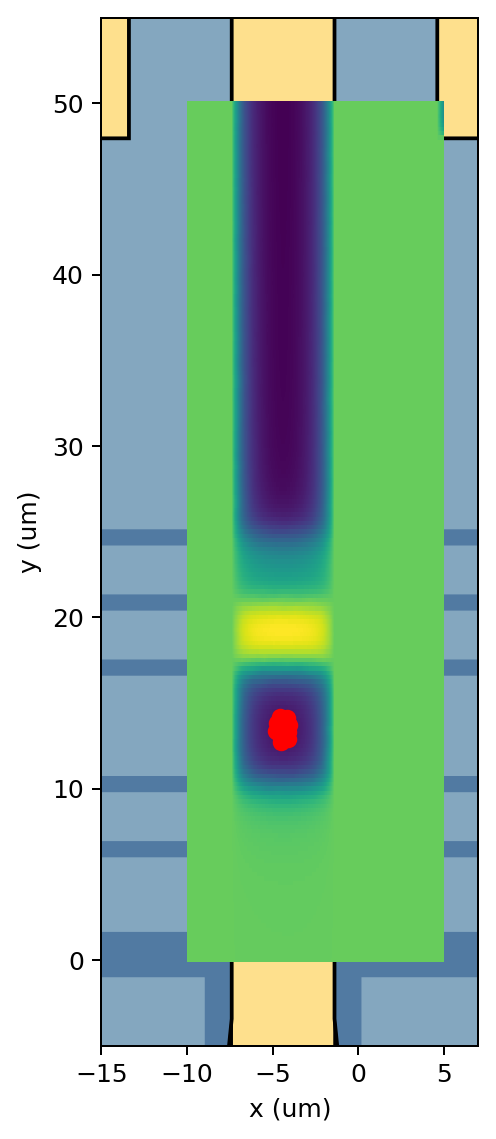

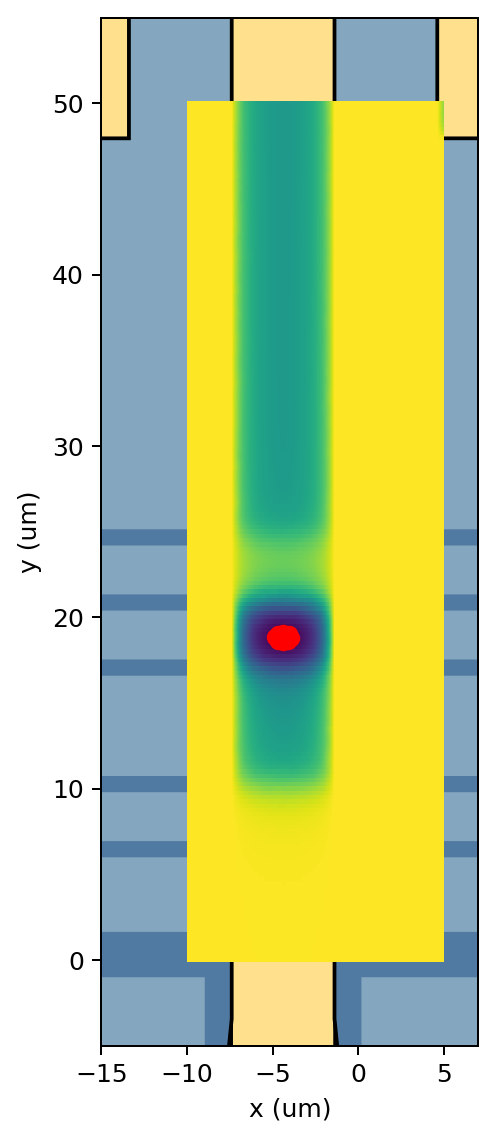

In [38]:
voltages = {
    'Barrier':-1,
    'Door1':-0.7,
    'Door2':-1,
    'Reservoir':0,
    'Sense':0,
    'ThinFilm':-1,
    'Top':-1,
    'Twiddle':0,
}

N = 10
min_spacing = 0.2
x0,y0 = -5,14
vpp = 3

coords = generate_coords_deterministic(int(N),x0,y0,min_spacing).flatten()*1e-6
coords = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=coords)

for twiddle in [-vpp/2,vpp/2]:
    voltages['Twiddle'] = twiddle
    x,y,z = ph.potential(p,voltages)
    fm = FullModel(ph.phi, voltages, **options)
    coords = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=coords)
    
    device.quickplot(plot_config)
    plt.pcolormesh(x,y,-z.T)
    plt.xlim(-15,7)
    plt.ylim(-5,55)
    for xi,yi in zip(coords[0::2],coords[1::2]):
        plt.plot(xi*1e6,yi*1e6,'ro')
    plt.ylabel("y (um)")
    plt.xlabel("x (um)")
    plt.show()

## Sommer Tanner loading

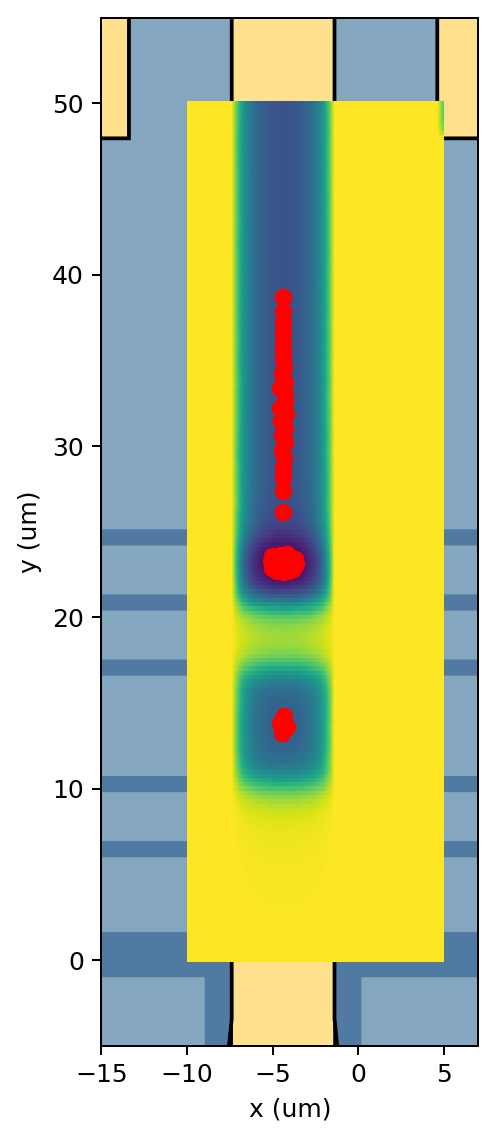

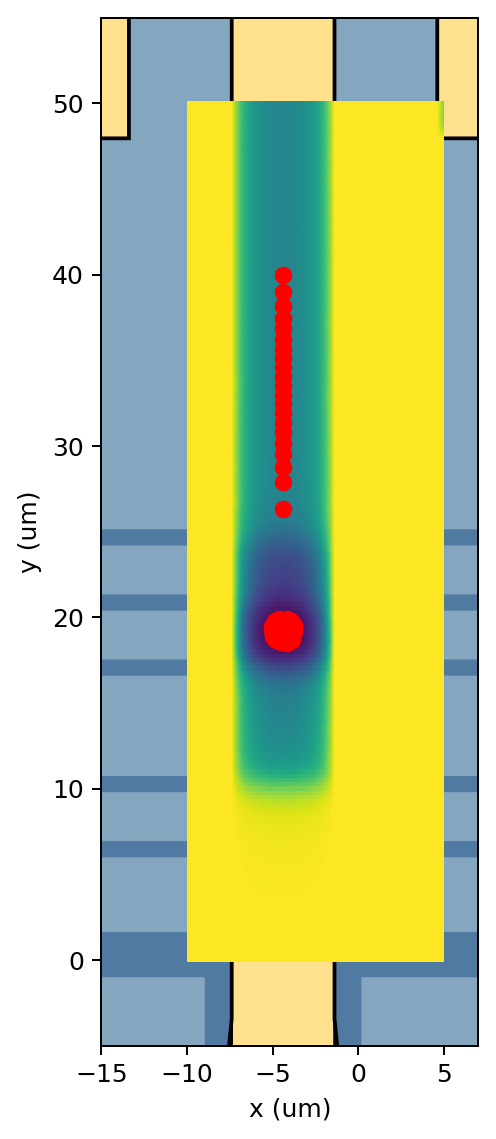

In [49]:
voltages = {
    'Barrier':-1,
    'Door1':0.5,
    'Door2':-1,
    'Reservoir':0,
    'Sense':0,
    'ThinFilm':-1,
    'Top':-1,
    'Twiddle':0,
}

N = 50
min_spacing = 0.2
x0,y0 = -5,30
vpp = 2

coords = generate_coords_deterministic(int(N),x0,y0,min_spacing).flatten()*1e-6
coords = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=coords)

for twiddle in [-vpp/2,vpp/2]:
    voltages['Twiddle'] = twiddle
    x,y,z = ph.potential(p,voltages)
    fm = FullModel(ph.phi, voltages, **options)
    coords = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=coords)
    
    device.quickplot(plot_config)
    plt.pcolormesh(x,y,-z.T)
    plt.xlim(-15,7)
    plt.ylim(-5,55)
    for xi,yi in zip(coords[0::2],coords[1::2]):
        plt.plot(xi*1e6,yi*1e6,'ro')
    plt.ylabel("y (um)")
    plt.xlabel("x (um)")
    plt.show()